In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
#%load_ext cudf.pandas
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import optuna

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/prediction-of-e-commerce-users/submission.csv
/kaggle/input/prediction-of-e-commerce-users/train_df.csv
/kaggle/input/prediction-of-e-commerce-users/test_df.csv


In [2]:
train = pd.read_csv('/kaggle/input/prediction-of-e-commerce-users/train_df.csv', parse_dates=['datetime'])
test = pd.read_csv('/kaggle/input/prediction-of-e-commerce-users/test_df.csv', parse_dates=['datetime'])

In [3]:
train.shape

(23376, 5)

In [4]:
test.shape

(2928, 4)

In [5]:
train.sample(8)

,datetime,e_users,promotion_1,promotion_2,promotion_3
6305,2022-09-20 17:00:00,50601,24.00,69.55,59.42
15416,2023-10-05 08:00:00,41755,16.62,91.85,80.29
14777,2023-09-08 17:00:00,38014,18.82,73.05,57.41
111,2022-01-05 15:00:00,63658,13.88,89.28,77.89
701,2022-01-30 05:00:00,56272,10.34,94.20,89.17
18244,2024-01-31 04:00:00,52879,13.08,95.12,90.39
5472,2022-08-17 00:00:00,42476,19.28,87.44,81.11
23075,2024-08-19 11:00:00,47888,24.27,87.59,63.21


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='e_users', ylabel='Count'>

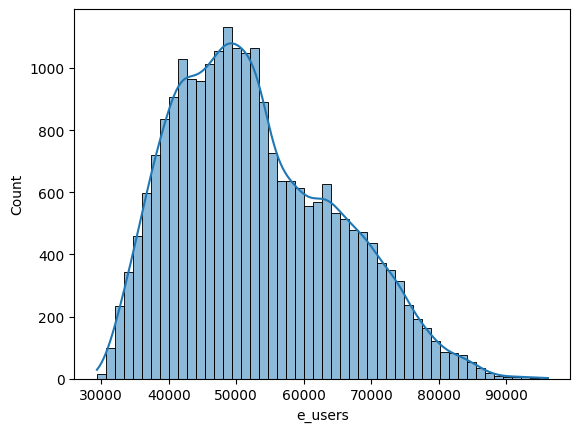

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(x='e_users', data=train, kde=True, bins=50,)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='e_users', ylabel='Count'>

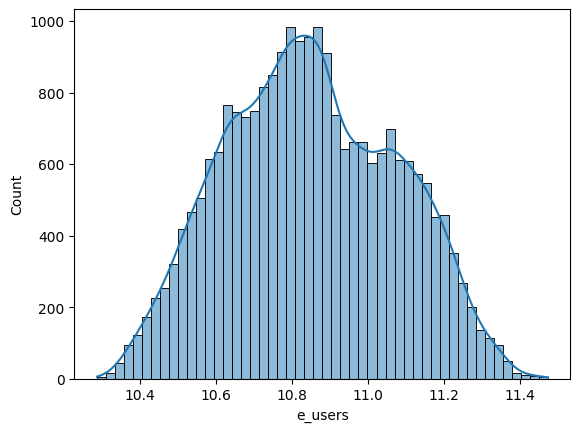

In [7]:
sns.histplot(np.log1p(train['e_users']), kde=True, bins=50)

As we can see from both plots that the target variable is rightly-skewed but with log transformed is approximately normally distributed.

In [8]:
train.isnull().sum()

datetime       0
e_users        0
promotion_1    0
promotion_2    0
promotion_3    0
dtype: int64

In [9]:
test.isnull().sum()

datetime       0
promotion_1    0
promotion_2    0
promotion_3    0
dtype: int64

In [10]:
train.describe()

,datetime,e_users,promotion_1,promotion_2,promotion_3
count,23376,23376.000000,23376.000000,23376.000000,23376.000000
mean,2023-05-02 23:29:59.999999744,52846.660207,15.598461,81.392785,74.453931
min,2022-01-01 00:00:00,29365.000000,1.050000,15.930000,41.600000
25%,2022-09-01 11:45:00,43573.750000,11.890000,75.200000,67.880000
50%,2023-05-02 23:30:00,51071.500000,15.130000,86.310000,76.715000
75%,2024-01-01 11:15:00,61238.250000,18.972500,91.640000,82.360000
max,2024-08-31 23:00:00,96130.000000,31.480000,100.050000,92.480000
std,NaN,11911.319411,4.827803,14.246880,9.991424


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23376 entries, 0 to 23375
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     23376 non-null  datetime64[ns]
 1   e_users      23376 non-null  int64         
 2   promotion_1  23376 non-null  float64       
 3   promotion_2  23376 non-null  float64       
 4   promotion_3  23376 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 913.3 KB


In [12]:
features = ['promotion_1', 'promotion_2', 'promotion_3']

In [13]:
def fe(df):
    
    df['day_of_year'] = df['datetime'].dt.dayofyear
    df['year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
    
    df['month'] = df['datetime'].dt.month
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    df['hour'] = df['datetime'].dt.hour
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    df['week'] = df['datetime'].dt.isocalendar().week
    df['sin_week'] = np.sin(2 * np.pi * df['week'] / 52).astype(float)
    df['cos_week'] = np.cos(2 * np.pi * df['week'] / 52).astype(float)

    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['sin_dayofweek'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['cos_dayofweek'] = np.cos(2 * np.pi * df['dayofweek'] / 7)  

    for lag in [1, 7, 10, 14, 24, 48, 72]:  
        for col in ['promotion_1', 'promotion_2', 'promotion_3']:
            df[f'{col}_lag_{lag}'] = df[col].shift(lag).fillna(0.0)
            df[f'{col}_diff_{lag}'] = df[col].diff(lag).fillna(0.0)
    

    df['day'] = df['datetime'].dt.day
    df['year'] = df['datetime'].dt.year

    df['on_season'] = np.where(df['datetime'].dt.month.isin([11, 12, 1, 2, 3, 4]), 1, 0)

    df['is_off_week'] = np.where(df['datetime'].dt.dayofweek.isin([2,3,4]), 1, 0)

    for period in [6, 12, 24, 48, 72]:
        for col in features:
            df[f'{col}_mean_{period}'] = df[col].rolling(period).mean()
            df[f'{col}_std_{period}'] = df[col].rolling(period).std()
            df[f'{col}_max_{period}'] = df[col].rolling(period).max()
            df[f'{col}_min_{period}'] = df[col].rolling(period).min()
            df[f'{col}_median_{period}'] = df[col].rolling(period).median()
    
    df.drop(['datetime'], axis=1, inplace=True)

    return df

In [14]:
def add_interact(df):
    for i, c1 in enumerate(features):
        for c2 in (features[i+1:]):
            m = f'{c1}*{c2}'
            df[m] = df[c1] * df[c2]
            a = f'{c1}+{c2}'
            df[a] = df[c1] + df[c2]
            d = f'{c1}/{c2}'
            df[d] = df[c1] / (df[c2] + 1e-5)
    return df

In [15]:
X = train.copy()
y = X.pop('e_users')
X = fe(X)
X = add_interact(X)

X_test = test.copy()
X_test = fe(X_test)
X_test = add_interact(X_test)

In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23376 entries, 0 to 23375
Columns: 148 entries, promotion_1 to promotion_2/promotion_3
dtypes: UInt32(1), float64(139), int32(6), int64(2)
memory usage: 25.8 MB


In [17]:
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

tscv = TimeSeriesSplit(n_splits=5)
oof_lgbm = np.zeros(len(y))
test_lgbm = np.zeros(len(X_test))

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 4000, 10000),
        'min_child_samples': trial.suggest_int('min_child_samples', 3, 50),
        'num_leaves': trial.suggest_int('num_leaves', 5, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2, log=True),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 8.0),
        'max_depth': trial.suggest_int('max_depth', 1, 13),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 11),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10,),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'goss']),
        'verbose': -1,
        'n_jobs': -1,
    }

    scores = []
    
    for fold, (train_index, valid_index) in enumerate(tscv.split(X, y), start=1):
        X_train, X_valid = X.iloc[train_index].copy(), X.iloc[valid_index].copy()
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
        lgbm = LGBMRegressor(**params, early_stopping_rounds=50, random_state=100).fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
        lgbm_pred = lgbm.predict(X_valid)
        fold_rmse = np.sqrt(mean_squared_error(y_valid, lgbm_pred))
        scores.append(fold_rmse)
    
    return np.mean(scores)
    
study = optuna.create_study(direction='minimize', study_name='LGBM-RMSE-Optimization', sampler=optuna.samplers.TPESampler(seed=100))
study.optimize(objective, n_trials=20)

print(f'Best cross-validation RMSE: {study.best_value:,.5f}')
print(f'Best parameters: {study.best_params}')

[I 2025-06-01 12:57:41,766] A new study created in memory with name: LGBM-RMSE-Optimization
[I 2025-06-01 12:57:51,224] Trial 0 finished with value: 3107.1673773634893 and parameters: {'n_estimators': 7260, 'min_child_samples': 16, 'num_leaves': 88, 'learning_rate': 0.0878729527635045, 'min_split_gain': 0.03775084952778052, 'max_depth': 2, 'reg_alpha': 6.707820098183061, 'reg_lambda': 9.084554453400418, 'colsample_bytree': 0.5683532948424765, 'min_child_weight': 5.7513582009430735, 'boosting_type': 'gbdt'}. Best is trial 0 with value: 3107.1673773634893.
[I 2025-06-01 12:57:59,522] Trial 1 finished with value: 3095.8797929053494 and parameters: {'n_estimators': 5112, 'min_child_samples': 8, 'num_leaves': 48, 'learning_rate': 0.17858405626628282, 'min_split_gain': 6.493465192714586, 'max_depth': 3, 'reg_alpha': 8.162431262509674, 'reg_lambda': 3.0155371437116494, 'colsample_bytree': 0.7158520918315608, 'min_child_weight': 9.400358166404123, 'boosting_type': 'gbdt'}. Best is trial 1 with

Best cross-validation RMSE: 3,019.05078
Best parameters: {'n_estimators': 8486, 'min_child_samples': 37, 'num_leaves': 31, 'learning_rate': 0.04240703399849636, 'min_split_gain': 1.292833945021509, 'max_depth': 4, 'reg_alpha': 3.8483059156800277, 'reg_lambda': 6.259533334869484, 'colsample_bytree': 0.6455815961528194, 'min_child_weight': 4.143843117716839, 'boosting_type': 'gbdt'}


In [18]:
import json

with open('/kaggle/working/best_lgbm_params.json', 'w') as f:
    json.dump(study.best_params, f)

In [19]:
final_model = LGBMRegressor(**study.best_params).fit(X, y)
test_lgbm = final_model.predict(X_test)

In [20]:
sub = pd.read_csv('/kaggle/input/prediction-of-e-commerce-users/submission.csv')
sub['e_users'] = test_lgbm
sub.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")
print(sub.head(8))

Your submission was successfully saved!
              datetime       e_users
0  2024-09-01 00:00:00  50792.533310
1  2024-09-01 01:00:00  48206.631484
2  2024-09-01 02:00:00  47862.245569
3  2024-09-01 03:00:00  45423.653638
4  2024-09-01 04:00:00  43650.969766
5  2024-09-01 05:00:00  41717.555395
6  2024-09-01 06:00:00  42867.621210
7  2024-09-01 07:00:00  43859.759588
